In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import glob
import cv2

In [4]:
df = pd.read_csv("/kaggle/input/pid-symbols/train (2).txt", names = ["path"]).reset_index(drop = True)
len(df)

27000

In [5]:
df["fnames"] = df["path"].str.split("/").str[2]
df["fnames"] = df["fnames"].str.split(".").str[0]

In [6]:
df

,path,fnames
0,./images/73_1280_1280.jpg,73_1280_1280
1,./images/142_2560_3200.jpg,142_2560_3200
2,./images/311_1920_4480.jpg,311_1920_4480
3,./images/129_3200_1920.jpg,129_3200_1920
4,./images/4_0_640.jpg,4_0_640
...,...,...
26995,./images/350_3200_1920.jpg,350_3200_1920
26996,./images/493_1280_5760.jpg,493_1280_5760
26997,./images/217_1920_3200.jpg,217_1920_3200
26998,./images/454_1920_5120.jpg,454_1920_5120


In [7]:
x = []
with open(f'/kaggle/input/pid-symbols/labels (2)/{df.fnames[4289]}.txt') as f:
    x.append([line[:-2] for line in f.readlines()])
    

In [8]:
x

[['20 0.066015625 0.729296875 0.05390625 0.0601562',
  '25 0.066015625 0.473828125 0.07421875 0.0742187']]

In [9]:
[i.split(" ") for i in x[0]]

[['20', '0.066015625', '0.729296875', '0.05390625', '0.0601562'],
 ['25', '0.066015625', '0.473828125', '0.07421875', '0.0742187']]

In [10]:
x = [[int(float(val)) if float(val) == int(float(val)) else float(val) for val in i.split()]for i in x[0]]
x

[[20, 0.066015625, 0.729296875, 0.05390625, 0.0601562],
 [25, 0.066015625, 0.473828125, 0.07421875, 0.0742187]]

In [11]:
from PIL import Image
import numpy as np

img = Image.open(f"/kaggle/input/pid-symbols/images (3)/{df.fnames[4289]}.jpg")
img = img.resize((640,640))
print(img.size)
img = np.array(img).astype(np.float32)
img/=255

(640, 640)


In [12]:
img.shape[0]

640

24.999999999999996 447.50001599999996
18.499999999999996 279.500016


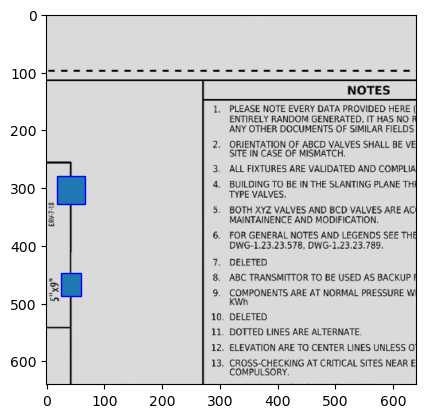

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
for box in x:
    s = img.shape
    print((box[1] - box[3]/2) * s[0], (box[2] - box[4]/2) * s[1])
    bb = patches.Rectangle(
        ((box[1] - box[3]/2) * s[0], (box[2] - box[4]/2) * s[1]), 
        box[3] * s[0],box[4] * s[1], 
        edgecolor="blue")
    ax.add_patch(bb)
 
ax.imshow(img)
plt.show()

In [14]:
trans = T.Compose([T.ToTensor()])

class pidData(Dataset):
    def __init__(self, df, img_dir, ann_dir, img_size, trans = None, train = True):
        self.df = df
        self.transform = trans
        self.train = train
        self.ann_dir = ann_dir
        self.img_dir = img_dir
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(f"{self.img_dir+self.df[idx]}.jpg").convert("RGB")
        img = img.resize((self.img_size, self.img_size))
        img = np.array(img).astype(np.float32)
        img/=255
        if self.transform is not None:
            img = self.transform(img)
        if (self.train == False):
            return img
            
        ann = []
        with open(f'{self.ann_dir+self.df[idx]}.txt') as f:
            ann.append([line[:-2] for line in f.readlines()])
        ann = [[int(float(val)) if float(val) == int(float(val)) else float(val) for val in i.split()]for i in ann[0]]
        boxes = []
        for i in ann:
            if i[3] <= 0 or i[4] <= 0:
                continue
            tmp = []
            tmp.append(float((i[1] - i[3]/2)*self.img_size))
            tmp.append(float((i[2] - i[4]/2)*self.img_size))
            tmp.append(float((i[1] + i[3]/2)*self.img_size))
            tmp.append(float((i[2] + i[4]/2)*self.img_size))
            boxes.append(tmp)
            tmp = []
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype = torch.float32)
        target["labels"] = torch.as_tensor([j[0] for j in ann], dtype=torch.int64)
        
        
        return img, target

In [15]:
x = []
empty_files = []
for i in range(len(df)):
    with open(f'/kaggle/input/pid-symbols/labels (2)/{df.fnames[i]}.txt') as f:
        x.append([line[:-2] for line in f.readlines()])
    if len(x[0]) == 0:
        empty_files.append(df.fnames[i])
    x = []

In [16]:
df = df[~df['fnames'].isin(empty_files)]

In [17]:
ex = df.sample(5).fnames.values
ex

array(['390_1920_3840', '497_0_2560', '461_1280_1280', '297_2560_2560',
       '345_3200_3200'], dtype=object)

In [18]:
samp = pidData(list(ex), "/kaggle/input/pid-symbols/images (3)/", "/kaggle/input/pid-symbols/labels (2)/", 320, trans = trans)

In [19]:
def custom_collate(batch):
    return tuple(zip(*batch))

In [20]:
dl = DataLoader(samp, batch_size=5, collate_fn=custom_collate)

In [21]:
# batch = next(iter(dl))
X, y = next(iter(dl))

In [22]:
X[0].shape, y[0]["boxes"].shape, y[0]["labels"].shape

(torch.Size([3, 320, 320]), torch.Size([7, 4]), torch.Size([7]))

In [23]:
y[0]

{'boxes': tensor([[119.7500,  31.0000, 134.7500,  55.7500],
         [  2.0000, 274.0000,  33.7500, 305.2500],
         [ 48.7500, 123.7500,  64.5000, 139.0000],
         [ 48.2500,  21.5000,  63.7500,  45.7500],
         [156.7500, 133.5000, 182.0000, 154.7500],
         [183.0000,  95.2500, 214.2500, 127.0000],
         [220.7500,  66.5000, 241.2500,  84.7500]]),
 'labels': tensor([13, 27, 16,  5, 10, 27, 20])}

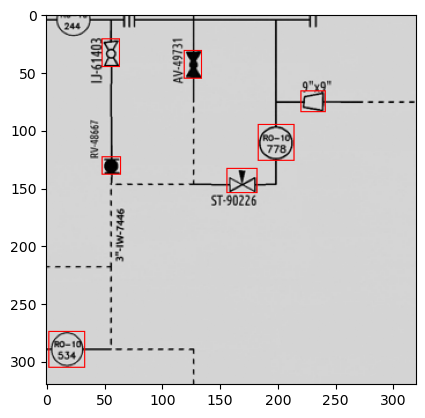

In [24]:
fig, ax = plt.subplots()
image = X[0].permute(1, 2, 0).detach().numpy()
image_with_rect = image.copy()

for x in y[0]['boxes']:
    cv2.rectangle(image_with_rect, (int(x[0].numpy()), int(x[1].numpy())), (int(x[2].numpy()), int(x[3].numpy())), (222, 0, 0), 1)
    
ax.imshow(image_with_rect)
plt.show()

In [25]:
import os
import shutil

# Define paths
source_path = "/kaggle/input/fasterrcnn-weights/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"  # Adjust based on your dataset name
cache_dir = "/root/.cache/torch/hub/checkpoints/"
target_path = os.path.join(cache_dir, "fasterrcnn_resnet50_fpn_coco-258fb6c6.pth")

# Create cache directory if it doesn’t exist
os.makedirs(cache_dir, exist_ok=True)

# Copy the file to the cache
shutil.copy(source_path, target_path)
print("Weights copied to cache!")

Weights copied to cache!


In [26]:
import torchvision.models.detection
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
print("Model loaded successfully!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weigh

Model loaded successfully!


In [27]:
import torchvision.models.detection
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
print("Model loaded successfully!")

Model loaded successfully!


In [37]:
train = df.head(500).fnames.values

In [38]:
len(train)

500

In [30]:
train_ds = pidData(list(train), "/kaggle/input/pid-symbols/images (3)/", "/kaggle/input/pid-symbols/labels (2)/", 640, trans = trans)
train_dl = DataLoader(train_ds, batch_size=5, collate_fn=custom_collate, shuffle=False)

In [31]:
X, y = next(iter(train_dl))

In [32]:
X[0].shape, y[0]["boxes"].shape, y[0]["labels"].shape

(torch.Size([3, 640, 640]), torch.Size([12, 4]), torch.Size([12]))

In [33]:
num_classes = 33
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [34]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.load with map_location=torch.device('cpu')
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [35]:
optimizer = optim.SGD(model.parameters(), lr = 2e-4, momentum=0.9, weight_decay=1e-4)
num_epochs = 30

In [36]:
checkpoint = torch.load('/kaggle/input/fasterrcnnn/pytorch/default/1/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epochs = checkpoint['epoch']

KeyError: 'state_dict'

In [44]:
import torch
import torchvision.models.detection

# Define the device (CPU since you don’t have CUDA)
device = torch.device('cpu')

# Load the model (without pre-trained weights initially)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model = model.to(device)

# Load the weights file directly
checkpoint = torch.load('/kaggle/input/fasterrcnnn/pytorch/default/1/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth', map_location=device)

# Load the weights into the model
model.load_state_dict(checkpoint)  # No 'state_dict' key needed

# Define an optimizer (since it’s not in the file)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set epoch manually (since it’s not in the file)
epochs = 0  # Or whatever starting epoch you want

print("Model weights loaded successfully!")

Model weights loaded successfully!


In [ ]:
# for images, targets in train_dl:
#     if str(targets[0]["boxes"].shape) == "torch.Size([0])":
#         print(targets)
#         break

In [41]:
checkpoint = torch.load('/kaggle/input/fasterrcnnn/pytorch/default/1/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epochs = checkpoint['epoch']

KeyError: 'state_dict'

In [45]:
import torch
import torchvision.models.detection

# Set device to CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Load the model without pre-trained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model = model.to(device)

# Load the weights file
weights_path = '/kaggle/input/fasterrcnnn/pytorch/default/1/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'
checkpoint = torch.load(weights_path, map_location=device)

# Load weights into the model
model.load_state_dict(checkpoint)
model.eval()  # Set to evaluation mode for inference
print("Model weights loaded successfully!")

# Define an optimizer (example)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set starting epoch
epochs = 0
print(f"Starting epoch: {epochs}")

# Optional: Test with dummy input
dummy_input = torch.rand(1, 3, 224, 224).to(device)
with torch.no_grad():
    predictions = model(dummy_input)
print("Predictions:", predictions[0].keys())

Using device: cpu
Model weights loaded successfully!
Starting epoch: 0
Predictions: dict_keys(['boxes', 'labels', 'scores'])


In [50]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Custom collate_fn to handle variable-sized targets
def custom_collate_fn(batch):
    images = [item[0] for item in batch]  # List of image tensors
    targets = [item[1] for item in batch]  # List of target dicts
    return images, targets

# Define num_epochs and train_dl
num_epochs = 2
# Assuming train_dl.dataset is your dataset with 30,000 images
# Limit to 30 images
sampler = SubsetRandomSampler(range(30))  # Sample first 30 images
train_dl = DataLoader(train_dl.dataset, batch_size=2, sampler=sampler, num_workers=0, collate_fn=custom_collate_fn)

# Ensure model is in training mode (assuming model, device, optimizer are defined)
model.to(device)
model.train()  # Explicitly set training mode

itr = 1
for epoch in range(num_epochs):
    print(f"Epoch #{epoch} started")
    epoch_loss = 0
    
    # Iterate over the DataLoader (limited to 30 images)
    for batch_idx, (images, targets) in enumerate(train_dl):
        # Move data to CPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass (should return a dict of losses in training mode)
        loss_dict = model(images, targets)  # Returns a dict like {'loss_classifier', ...}
        losses = sum(loss for loss in loss_dict.values())  # Sum the loss values
        
        # Accumulate loss for the epoch
        epoch_loss += losses.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print progress every iteration
        if itr % 1 == 0:
            print(f"Epoch #{epoch}, Iteration #{itr}, Loss: {losses.item():.4f}")
        
        itr += 1
    
    # Print epoch summary
    print(f"Epoch #{epoch} finished, Total Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch #0 started
Epoch #0, Iteration #1, Loss: 2.1361
Epoch #0, Iteration #2, Loss: 1.4623
Epoch #0, Iteration #3, Loss: 1.9284
Epoch #0, Iteration #4, Loss: 0.7344
Epoch #0, Iteration #5, Loss: 1.9435
Epoch #0, Iteration #6, Loss: 1.7058
Epoch #0, Iteration #7, Loss: 2.1087
Epoch #0, Iteration #8, Loss: 0.6099
Epoch #0, Iteration #9, Loss: 1.9029
Epoch #0, Iteration #10, Loss: 1.3392
Epoch #0, Iteration #11, Loss: 2.2494
Epoch #0, Iteration #12, Loss: 1.4566
Epoch #0, Iteration #13, Loss: 1.9700
Epoch #0, Iteration #14, Loss: 1.9985
Epoch #0, Iteration #15, Loss: 1.7697
Epoch #0 finished, Total Loss: 25.3156
Epoch #1 started
Epoch #1, Iteration #16, Loss: 1.4390
Epoch #1, Iteration #17, Loss: 1.6067
Epoch #1, Iteration #18, Loss: 1.6969
Epoch #1, Iteration #19, Loss: 0.6374
Epoch #1, Iteration #20, Loss: 1.4321
Epoch #1, Iteration #21, Loss: 1.9587
Epoch #1, Iteration #22, Loss: 1.7592
Epoch #1, Iteration #23, Loss: 1.4978
Epoch #1, Iteration #24, Loss: 1.7536
Epoch #1, Iteration #25,

In [47]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Custom collate_fn to handle variable-sized targets
def custom_collate_fn(batch):
    images = [item[0] for item in batch]  # List of image tensors
    targets = [item[1] for item in batch]  # List of target dicts
    return images, targets

# Define num_epochs and train_dl
num_epochs = 2
# Assuming train_dl.dataset is your dataset with 30,000 images
# Limit to 30 images
sampler = SubsetRandomSampler(range(30))  # Sample first 30 images
train_dl = DataLoader(train_dl.dataset, batch_size=2, sampler=sampler, num_workers=0, collate_fn=custom_collate_fn)

itr = 1
for epoch in range(num_epochs):
    print(f"Epoch #{epoch} started")
    epoch_loss = 0
    
    # Iterate over the DataLoader (limited to 30 images)
    for batch_idx, (images, targets) in enumerate(train_dl):
        # Move data to CPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)  # Returns a dict of losses
        losses = sum(loss for loss in loss_dict.values())
        
        # Accumulate loss for the epoch
        epoch_loss += losses.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print progress every iteration
        if itr % 1 == 0:
            print(f"Epoch #{epoch}, Iteration #{itr}, Loss: {losses.item():.4f}")
        
        itr += 1
    
    # Print epoch summary
    print(f"Epoch #{epoch} finished, Total Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch #0 started


AttributeError: 'list' object has no attribute 'values'

In [48]:


# Define num_epochs and train_dl (example placeholders, adjust as needed)
num_epochs = 2  # Set a small number for testing
# train_dl should be your DataLoader with images and targets

itr = 1
for epoch in range(num_epochs):
    print(f"Epoch #{epoch} started")
    epoch_loss = 0
    
    # Iterate over the DataLoader
    for batch_idx, (images, targets) in enumerate(train_dl):
        # Move data to CPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)  # Returns a dict of losses
        losses = sum(loss for loss in loss_dict.values())
        
        # Accumulate loss for the epoch
        epoch_loss += losses.item()  # Use .item() to get scalar value
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print progress more frequently to avoid timeout and track progress
        if itr % 1 == 0:  # Adjusted to print every 10 iterations
            print(f"Epoch #{epoch}, Iteration #{itr}, Loss: {losses.item():.4f}")
        
        itr += 1
    
    # Print epoch summary
    print(f"Epoch #{epoch} finished, Total Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch #0 started


AttributeError: 'list' object has no attribute 'values'

In [ ]:
itr = 1
model.to(device)
model.train()
for epoch in range(num_epochs):
    print("started")
    epoch_loss = 0
    for images, targets in train_dl:
        print("start")
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss
        
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 2 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
        print("ended")
    

    print(f"Epoch #{epoch} loss: {epoch_loss}")

In [51]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [52]:
val = [df.iloc[1001].fnames]
val_ds = pidData(val, "/kaggle/input/pid-symbols/images (3)/", "/kaggle/input/pid-symbols/labels (2)/", 320, trans = trans)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

In [53]:
X, y= next(iter(val_dl))

In [54]:
X.shape

torch.Size([1, 3, 320, 320])

In [55]:
y

{'boxes': tensor([[[ 57.0000, 189.5000,  70.7500, 196.7500],
          [ 37.7500, 259.7500,  51.2500, 273.5000]]]),
 'labels': tensor([[21, 15]])}

In [56]:
model.to(device)
model.eval()
out = model(list(X.to(device)))

In [58]:
out_boxes = out[0]["boxes"]
out_labels = out[0]["labels"]
out_scores = out[0]["scores"]

In [59]:
out_scores

tensor([0.1672, 0.1248, 0.1231, 0.0907, 0.0862, 0.0831, 0.0757, 0.0678, 0.0666,
        0.0650, 0.0606, 0.0528], grad_fn=<IndexBackward0>)

In [71]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# [Your earlier training code here...]
# After training, switch to evaluation
model.eval()

# Use a single image or batch from train_dl for inference
with torch.no_grad():
    for images, targets in train_dl:  # Take one batch
        images = list(image.to(device) for image in images)
        predictions = model(images)  # List of prediction dicts
        break  # Only process one batch

# Extract and filter predictions
out_boxes = predictions[0]['boxes']
out_labels = predictions[0]['labels']
out_scores = predictions[0]['scores']

mask = out_scores >= 0.45
if out_boxes.numel() > 0:
    out_boxes = out_boxes[mask].data.cpu().numpy().astype(np.int32)
    out_labels = out_labels[mask].data.cpu().numpy().astype(np.int32)
    out_scores = out_scores[mask].data.cpu().numpy().astype(np.float32)
else:
    out_boxes = np.array([], dtype=np.int32).reshape(0, 4)
    out_labels = np.array([], dtype=np.int32)
    out_scores = np.array([], dtype=np.float32)

print("Filtered boxes:", out_boxes)
print("Filtered labels:", out_labels)
print("Filtered scores:", out_scores)

Filtered boxes: []
Filtered labels: []
Filtered scores: []


In [79]:
out_boxes = out_boxes[out_scores >= 0.45].data.cpu().numpy().astype(np.int32)
out_labels = out_labels[out_scores >= 0.45].data.cpu().numpy().astype(np.int32)

AttributeError: 'memoryview' object has no attribute 'cpu'

In [73]:
out_boxes

array([], shape=(0, 4), dtype=int32)

In [74]:
out_labels

array([], dtype=int32)

In [75]:
y

{'boxes': tensor([[[ 57.0000, 189.5000,  70.7500, 196.7500],
          [ 37.7500, 259.7500,  51.2500, 273.5000]]]),
 'labels': tensor([[21, 15]])}

In [76]:
og_boxes  = y["boxes"].squeeze().data.cpu().numpy().astype(np.int32)
og_labels  = y["labels"].squeeze().data.cpu().numpy().astype(np.int32)

In [77]:
og_boxes

array([[ 57, 189,  70, 196],
       [ 37, 259,  51, 273]], dtype=int32)

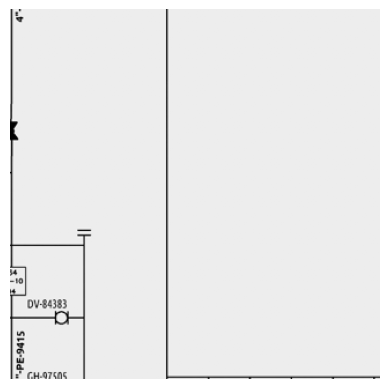

In [78]:
def generate_color_map(num_classes):
    colors = []
    for i in range(num_classes):
        hue = i / num_classes
        rgb = plt.cm.hsv(hue)[:3]
        colors.append(tuple(np.array(rgb) * 255))
    return colors

num_classes = 33
class_colors = generate_color_map(num_classes)


fig, ax = plt.subplots()

image = X[0].permute(1, 2, 0).detach().numpy()
image_with_rect = image.copy()
for x, label in zip(out_boxes, out_labels):
    x_min, y_min, x_max, y_max = x
    color = class_colors[label.item()]
    color = tuple(c / 255.0 for c in color)
    cv2.rectangle(image_with_rect, (x_min, y_min), (x_max, y_max), color, 1)
    
    text = f"Class: {label.item()}"
    ax.text(x_min, y_min - 5, text, color='white', fontsize=8, weight='bold', 
            bbox=dict(facecolor=color, edgecolor=color, pad=0, alpha=0.7))

ax.imshow(image_with_rect)
plt.axis('off')
plt.show()

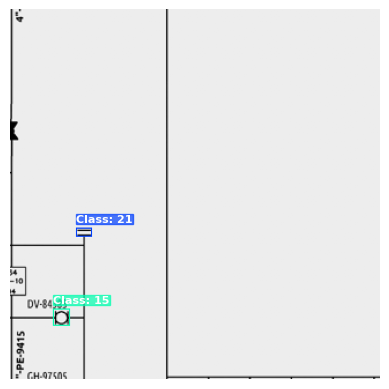

In [81]:
fig, ax = plt.subplots()

image = X[0].permute(1, 2, 0).detach().numpy()
image_with_rect = image.copy()
for x, label in zip(og_boxes, og_labels):
    x_min, y_min, x_max, y_max = x
    color = class_colors[label.item()]
    color = tuple(c / 255.0 for c in color)
    cv2.rectangle(image_with_rect, (x_min, y_min), (x_max, y_max), color, 1)
    
    text = f"Class: {label.item()}"
    ax.text(x_min, y_min - 5, text, color='white', fontsize=8, weight='bold', 
            bbox=dict(facecolor=color, edgecolor=color, pad=0, alpha=0.7))

ax.imshow(image_with_rect)
plt.axis('off')
plt.show()

In [83]:
state = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
        }
savepath = './pandid.t7'
torch.save(state,savepath)

In [ ]:
# fig, ax = plt.subplots()
# image = X[0].permute(1, 2, 0).detach().numpy()
# image_with_rect = image.copy()

# for x in out_boxes:
#     cv2.rectangle(image_with_rect, (x[0], x[1]), (x[2], x[3]), (222, 0, 0), 1)
    
# ax.imshow(image_with_rect)
# plt.show()